## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

from dvn.dvn_fcn import DeepVesselNetFCN
from dvn.solver import Solver
from dvn.data_utils import SyntheticData
import dvn.misc as ms

torch.set_default_tensor_type('torch.FloatTensor')
# set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load the data

In [2]:
patch_size=64

train_synthetic = SyntheticData(root_path="./data/train/", patch_size=patch_size)
val_and_test = SyntheticData(root_path="./data/val/", patch_size=patch_size)
val_synthetic = val_and_test[:int(len(val_and_test)/2)]
test_synthetic = val_and_test[int(len(val_and_test)/2):]


## Visualize part of the data

In [3]:
print("Train size: %i" % len(train_synthetic))
print("Validation size: %i" % len(val_synthetic))
print("Img size: ", train_synthetic[0][0].size())
print("Segmentation size: ", train_synthetic[0][1].size())

Train size: 110
Validation size: 13
Img size:  torch.Size([1, 64, 64, 64])
Segmentation size:  torch.Size([64, 64, 64])


## Design network

In [4]:
train_loader = torch.utils.data.DataLoader(train_synthetic, batch_size=10, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_synthetic, batch_size=2, shuffle=False, num_workers=2)

## Train network

In [5]:
model = DeepVesselNetFCN(batchnorm=True, dropout=True)
model.to(device)

optim_args_SGD = {"lr": 1e-2, "weight_decay": 0.01, "momentum": 0.9}
optim_args_ADAM = {"lr": 1e-2, "weight_decay": 0.01}

solver = Solver(optim_args=optim_args_SGD, optim=torch.optim.SGD)
solver.train(model, train_loader, val_loader, log_nth=5, num_epochs=20)

START TRAIN
[Iteration 5/220] TRAIN loss: -4.888
[Iteration 10/220] TRAIN loss: -6.446
[Epoch 1/20] TRAIN acc/loss/dice: 0.964/-6.446/0.718
[Epoch 1/20] VAL   acc/loss/dice: 0.026/-4.848/0.718
[Iteration 16/220] TRAIN loss: -7.276
[Iteration 21/220] TRAIN loss: -7.620
[Epoch 2/20] TRAIN acc/loss/dice: 0.979/-7.620/0.826
[Epoch 2/20] VAL   acc/loss/dice: 0.037/-4.926/0.826
[Iteration 27/220] TRAIN loss: -7.224
[Iteration 32/220] TRAIN loss: -7.938
[Epoch 3/20] TRAIN acc/loss/dice: 0.985/-7.938/0.828
[Epoch 3/20] VAL   acc/loss/dice: 0.976/-9.727/0.828
[Iteration 38/220] TRAIN loss: -8.055
[Iteration 43/220] TRAIN loss: -7.538
[Epoch 4/20] TRAIN acc/loss/dice: 0.989/-7.538/0.863
[Epoch 4/20] VAL   acc/loss/dice: 0.990/-9.886/0.863
[Iteration 49/220] TRAIN loss: -7.933
[Iteration 54/220] TRAIN loss: -7.688
[Epoch 5/20] TRAIN acc/loss/dice: 0.989/-7.688/0.865
[Epoch 5/20] VAL   acc/loss/dice: 0.989/-9.896/0.865
[Iteration 60/220] TRAIN loss: -8.137
[Iteration 65/220] TRAIN loss: -7.428
[Ep

## Test network

In [12]:
val_and_test = SyntheticData(root_path="./data/val/", patch_size=patch_size, mode="test")
test_synthetic = val_and_test[int(len(val_and_test)/2):]


for i in range(len(test_synthetic)):
    volume, segmentation = test_synthetic[i]
    volume = volume.unsqueeze(0)
    output = ms.test(model, volume)
    dice = ms.dice_coeff(output, segmentation, pred=True).detach().cpu().numpy()

torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.93963444
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.9422885
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.94367355
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.94455785
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.9478182
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.94087034
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.94314915
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.9504907
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.9462275
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.942931
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.9452157
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.93958837
torch.Size([1, 325, 304, 600])
Dice coefficient of output:  0.9456436


## Visualize outputs


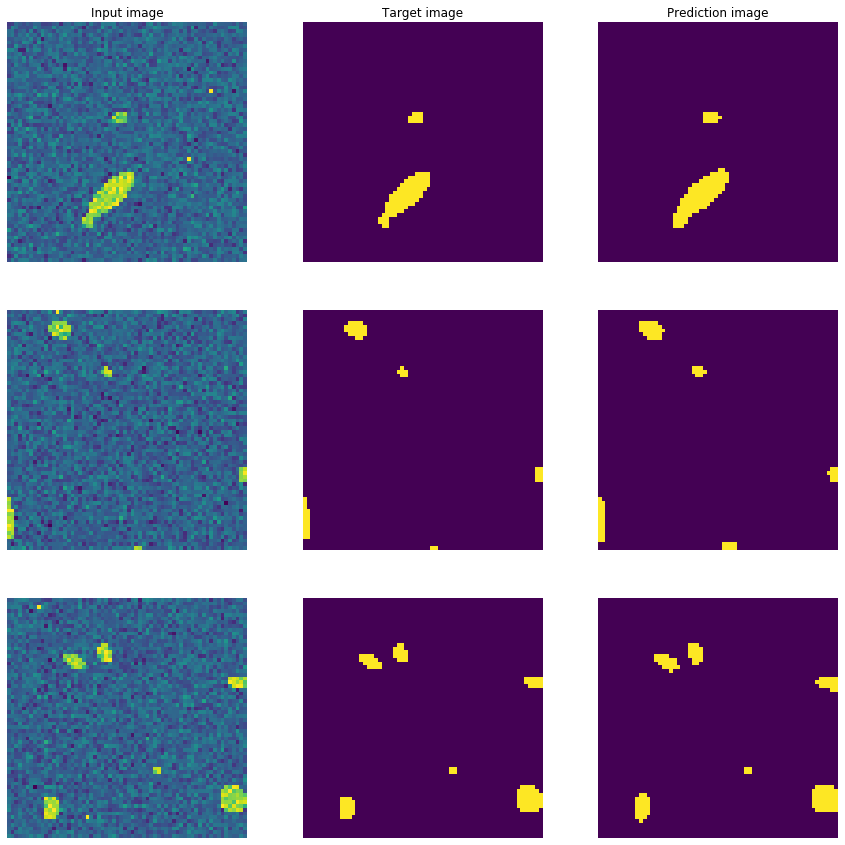

In [4]:
# model = model.best_val_model
model = DeepVesselNetFCN(batchnorm=True,dropout=True)
model = torch.load("models/deepvesselnet_final_batchnorm+dropout.model")
num_example_imgs = 3
plt.figure(figsize=(15, 5 * num_example_imgs))
model.eval()
for i, (inputs, targets) in enumerate(val_synthetic[:num_example_imgs]):
    
    inputs, targets = inputs.to(device, dtype=torch.float).unsqueeze(0), targets.to(device)
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)

    inputs, targets, preds = inputs.cpu().numpy(), targets.cpu().numpy(), preds.squeeze(0).cpu().numpy()
    
    # inputs
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(inputs[0,0,5])
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(targets[5])
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(preds[5])
    if i == 0:
        plt.title("Prediction image")

## Train with noisy data


In [ ]:
patch_size=64

train_synthetic_noisy = SyntheticData(root_path="./noisy_data/train/", patch_size=patch_size)
val_synthetic_noisy = SyntheticData(root_path="./noisy_data/val/", patch_size=patch_size)

print("DONE")

train_noisy_loader = torch.utils.data.DataLoader(train_synthetic_noisy, 
                                                  batch_size=10, shuffle=True, num_workers=1)
val_noisy_loader = torch.utils.data.DataLoader(val_synthetic_noisy, 
                                                batch_size=2, shuffle=False, num_workers=1)

model_noisy = DeepVesselNetFCN(dropout=True)
model_noisy.to(device)

optim_args_SGD = {"lr": 1e-2, "weight_decay": 0, "momentum": 0.9}
optim_args_Adam = {"lr": 1e-2, "weight_decay": 0}

solver_noisy = Solver(optim_args=optim_args_SGD, optim=torch.optim.SGD)
solver_noisy.train(model_noisy, train_noisy_loader, val_noisy_loader, log_nth=5, num_epochs=10)

In [ ]:
# model_noisy = model_noisy.best_val_model
num_example_imgs = 5
plt.figure(figsize=(15, 5 * num_example_imgs))
model_noisy.eval()
for i, (inputs, targets) in enumerate(val_synthetic[:num_example_imgs]):
    
    inputs, targets = inputs.to(device, dtype=torch.float).unsqueeze(0), targets.to(device)
    
    outputs = model_noisy.forward(inputs)
    _, preds = torch.max(outputs, 1)

    inputs, targets, preds = inputs.cpu().numpy(), targets.cpu().numpy(), preds.squeeze(0).cpu().numpy()
    
    # inputs
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(inputs[0,0,5])
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(targets[5])
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(preds[5])
    if i == 0:
        plt.title("Prediction image")


## Save models

In [13]:
# Model trained on ideal synthetic dataset
os.makedirs("models", exist_ok=True)
model.save("models/deepvesselnet_final_batchnorm+dropout.model")

# # Model trained on noisy synthetic dataset
# os.makedirs("models", exist_ok=True)
# model_noisy.save("models/deepvesselnet_noisy2.model")

Saving model... models/deepvesselnet_final_batchnorm+dropout.model


/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DeepVesselNetFCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/dshah/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked fo